In [14]:
#!/usr/bin/env python
# Author: Fred Faloona
# epoch: Pandemic years

import matplotlib.pyplot as plt

import pandas
import numpy as np
from datetime import datetime, timedelta

import requests
import os

covidcnts_file="/Users/fredafal/Downloads/COVID-19_aantallen_gemeente_cumulatief.csv"

        
def download_covid_nums():
    url = 'https://data.rivm.nl/covid-19/COVID-19_aantallen_gemeente_cumulatief.csv'
    # may want to find size and take last part
    # fsize = int(requests.get(url, stream=True).headers['Content-length'])
    # bytes_to_get = 1000000
    # begin = str(fsize - bytes_to_get)
    # end = str(fsize)
    # range_s = f'bytes={begin}-{fsize}'
    # r = requests.get(url, headers= {"range": range_s })
    r = requests.get(url, allow_redirects=True)
    f = open(covidcnts_file, 'wb')
    f.write(r.content)
    f.close()
    
    
def get_covid_df_days(df,days):
    now = datetime.now()
    dtnow_str = now.strftime("%Y-%m-%d") + " 10:00:00"
    beg_date = now - timedelta(days=days)
    dtbeg_str = beg_date.strftime("%Y-%m-%d") + " 10:00:00"

    dfwindow = df[(df['Date_of_report'] > dtbeg_str) & (df['Date_of_report'] <= dtnow_str)]
    return dfwindow

def get_covid_dfdif_days(df,days,enddate=None):
    if enddate is None:
        now = datetime.now()
    else:
        now = datetime.strptime(enddate, '%Y-%m-%d')
    dtnow_str = now.strftime("%Y-%m-%d") + " 10:00:00"
    beg_date = now - timedelta(days=days)
    dtbeg_str = beg_date.strftime("%Y-%m-%d") + " 10:00:00"
    
    dfmin = df[(df['Date_of_report'] == dtbeg_str)][['Municipality_name','Total_reported','Hospital_admission','Deceased']]
    # This will assure NaN (ie. cases not attributed to a municipality) in this field get included in the groupby sum.
    dfmin['Municipality_name'] = dfmin['Municipality_name'].astype(str)
    dfmin= dfmin.groupby('Municipality_name', as_index=False).sum()
    dfmin.set_index('Municipality_name',inplace=True)
    
    dfmax = df[(df['Date_of_report'] == dtnow_str)][['Municipality_name','Total_reported','Hospital_admission','Deceased']]
    # This will assure NaN (ie. cases not attributed to a municipality) in this field get included in the groupby sum.
    dfmax['Municipality_name'] = dfmax['Municipality_name'].astype(str)
    dfmax= dfmax.groupby('Municipality_name', as_index=False).sum()
    dfmax.set_index('Municipality_name',inplace=True)
    return dfmax.sub(dfmin)
    

def get_file_end_datetime():
    with open(covidcnts_file, "rb") as file:
        file.seek(-2, os.SEEK_END)
        while file.read(1) != b'\n':
            file.seek(-2, os.SEEK_CUR) 
        lastline = file.readline().decode()
        date,*strs = lastline.split(';')
        return datetime.strptime(date, '%Y-%m-%d %H:%M:%S')
        
    
def cleanup():
    os.remove(covidcnts_file)


download_covid_nums()

df = pandas.read_csv(covidcnts_file, sep=';')

df1 = get_covid_df_days(df,14)
dfdif = get_covid_dfdif_days(df,1)

print(df1.loc[df1['Municipality_name'] == 'Amsterdam'])

             Date_of_report Municipality_code Municipality_name  \
110206  2021-01-07 10:00:00            GM0363         Amsterdam   
110570  2021-01-08 10:00:00            GM0363         Amsterdam   
110934  2021-01-09 10:00:00            GM0363         Amsterdam   
111298  2021-01-10 10:00:00            GM0363         Amsterdam   
111662  2021-01-11 10:00:00            GM0363         Amsterdam   
112026  2021-01-12 10:00:00            GM0363         Amsterdam   
112390  2021-01-13 10:00:00            GM0363         Amsterdam   
112754  2021-01-14 10:00:00            GM0363         Amsterdam   
113118  2021-01-15 10:00:00            GM0363         Amsterdam   
113482  2021-01-16 10:00:00            GM0363         Amsterdam   
113846  2021-01-17 10:00:00            GM0363         Amsterdam   
114210  2021-01-18 10:00:00            GM0363         Amsterdam   
114574  2021-01-19 10:00:00            GM0363         Amsterdam   
114938  2021-01-20 10:00:00            GM0363         Amsterda

In [15]:
filedate = get_file_end_datetime()
today = datetime.today()
lastdate = filedate.date().strftime('%Y-%m-%d')
print(today,lastdate,today > filedate)
if today.day > filedate.day:
   print(f'filedate {lastdate} doesn\'t match now {today.date()}')
   today = datetime.strptime(lastdate,'%Y-%m-%d')
else:
    print(f'Todays publushed data {lastdate}')


2021-01-20 15:28:43.990419 2021-01-20 True
Todays publushed data 2021-01-20


In [16]:
dfdif = get_covid_dfdif_days(df,14,enddate=lastdate)

print(dfdif.sum())
print(dfdif.loc[ 'Amsterdam' , : ])

Total_reported        85878.0
Hospital_admission     1094.0
Deceased               1253.0
dtype: float64
Total_reported        3332.0
Hospital_admission      70.0
Deceased                47.0
Name: Amsterdam, dtype: float64


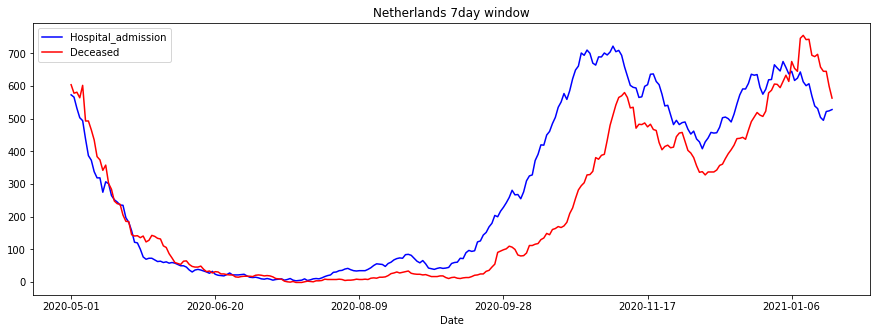

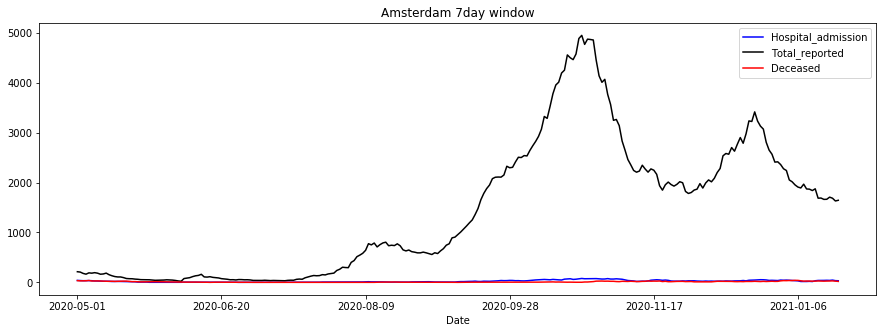

In [17]:
DIFF_WINDOW = 7

#today = datetime.now()
#today -= timedelta(days=1)
today_str = today.strftime("%Y-%m-%d")

begin_str = '2020-05-01'
begindate = datetime.strptime(begin_str, '%Y-%m-%d')
nextday = begindate


dates = []
sums = []
dfsum = pandas.DataFrame([],columns=['Total_reported','Hospital_admission','Deceased'])
dfamsterdam = dfsum



while begindate < today:
    next_str = begindate.strftime('%Y-%m-%d')
    dates.append(next_str)
    dfdif = get_covid_dfdif_days(df,DIFF_WINDOW,enddate=next_str)
    newsum = dfdif.sum().to_frame().transpose()
    dfsum = dfsum.append(newsum, ignore_index=True)
    newam = dfdif.loc[ 'Amsterdam' , : ].to_frame().transpose()
    dfamsterdam = dfamsterdam.append(newam, ignore_index=True)
    begindate += timedelta(days=1)
    
dfsum['Date'] = dates
dfamsterdam['Date'] = dates

# show only hospitalizations and mortality for all of The Netherlands
ax = dfsum.plot(kind="line", x="Date", y="Hospital_admission", color='blue',figsize=(15,5),title=f'Netherlands {DIFF_WINDOW}day window')
#dfsum.plot(kind="line", x="Date", y="Total_reported",  ax=ax, color="black")
dfsum.plot(kind="line",x="Date",y="Deceased",ax=ax,color="red")

# show all for only Amsterdam
ax = dfamsterdam.plot(kind="line", x="Date", y="Hospital_admission", color='blue',figsize=(15,5), title=f'Amsterdam {DIFF_WINDOW}day window')
dfamsterdam.plot(kind="line", x="Date", y="Total_reported",  ax=ax, color="black")
dfamsterdam.plot(kind="line",x="Date",y="Deceased",ax=ax,color="red")

plt.show()


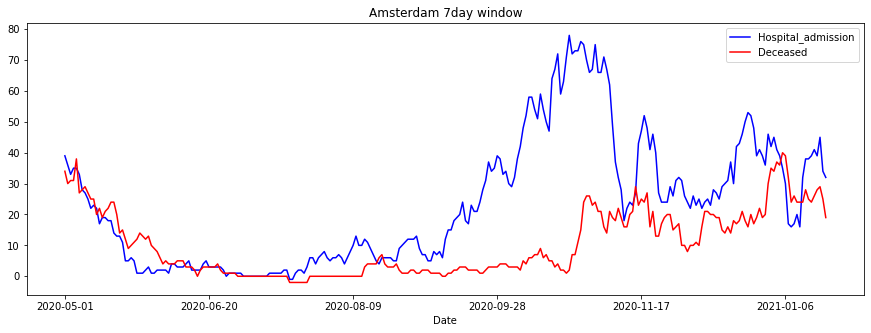

In [18]:
# show only hospitalizations and mortality for only Amsterdam
ax = dfamsterdam.plot(kind="line", x="Date", y="Hospital_admission", color='blue',figsize=(15,5), title=f'Amsterdam {DIFF_WINDOW}day window')
#dfamsterdam.plot(kind="line", x="Date", y="Total_reported",  ax=ax, color="black")
dfamsterdam.plot(kind="line",x="Date",y="Deceased",ax=ax,color="red")

plt.show()

In [ ]:
# Get counts for all Netherlands and only Amsterdam in specific time window
dfdif = get_covid_dfdif_days(df,14,enddate='2020-11-14')
print(dfdif.sum())
print(dfdif.loc[ 'Amsterdam' , : ])

In [2]:
cleanup()